# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import (
    Dense,
    Flatten,
    Dropout,
    Conv2D,
    MaxPooling2D,
    BatchNormalization,
)
# from keras.optimizers import SGD
from tensorflow.compat.v1.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf

# Parameters for Model Training

In [2]:
batch_size = 32  # Number of samples per gradient update
num_classes = 10  # Total number of classes in the dataset
epochs = 100  # Number of epochs to train the model
data_augmentation = True  # Flag to determine whether to use data augmentation

# Load and Preprocess the CIFAR-10 Dataset

In [3]:
(train_x, train_y), (test_x, test_y) = cifar10.load_data()

# Resize Images to 16x16

In [4]:
train_x = tf.image.resize(train_x, (16, 16)).numpy()
test_x = tf.image.resize(test_x, (16, 16)).numpy()

# Exploratory Data Analysis (EDA)

In [5]:
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

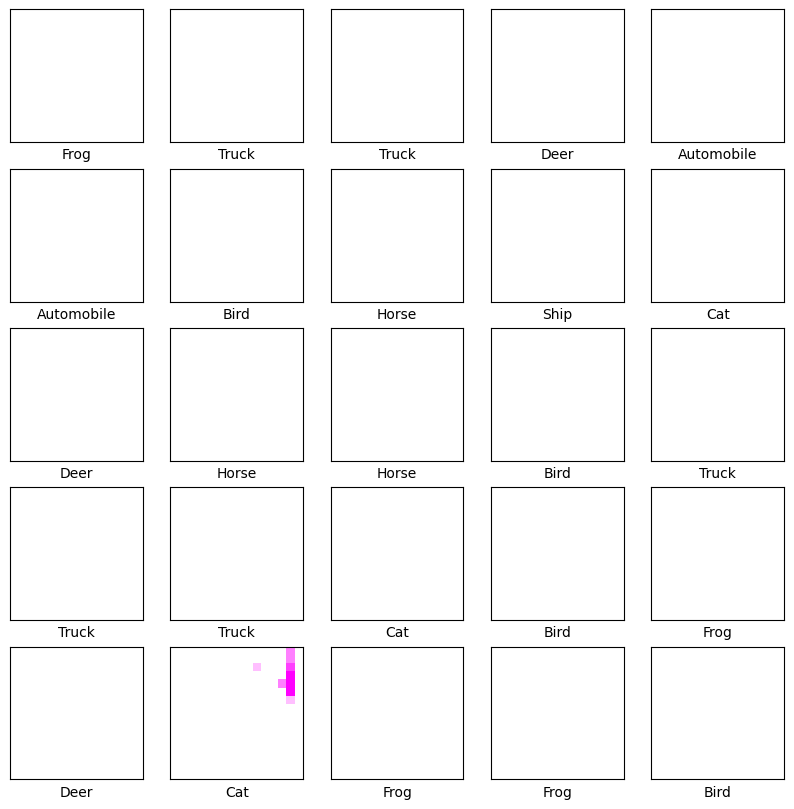

In [6]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_x[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_y[i][0]])
plt.show()

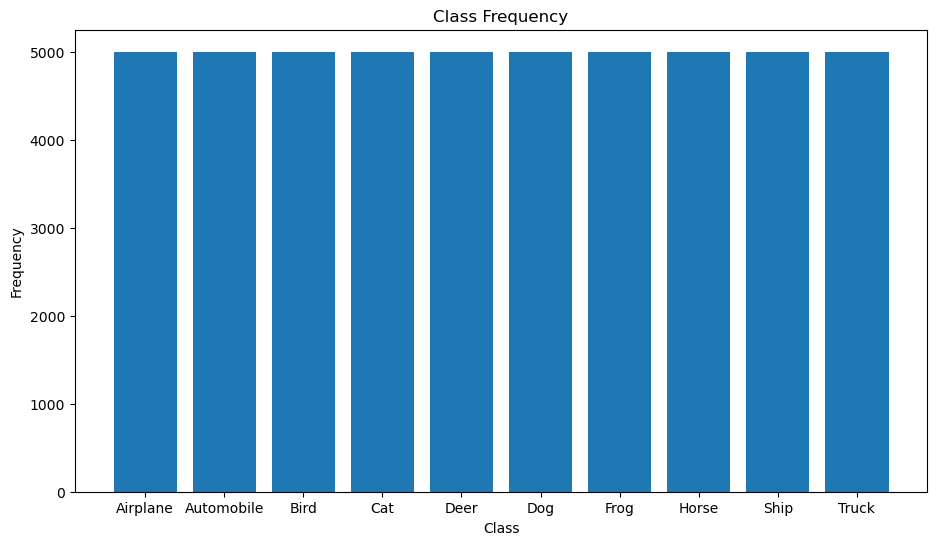

In [7]:
# Bar chart showing distribution of classes in training set
plt.figure(figsize=(11, 6))
unique, counts = np.unique(train_y, return_counts=True)

plt.bar(unique, counts)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(unique, class_names)
plt.show()

# Preprocess the Data with One-Hot Encoding

In [8]:
# Convert class vectors to binary class matrices
train_y = to_categorical(train_y, num_classes)
test_y = to_categorical(test_y, num_classes)

In [9]:
# Normalize pixel values to the range [0, 1]to aid in training convergence
train_x = train_x.astype("float32") / 255.0
test_x = test_x.astype("float32") / 255.0

# Define the CNN model

In [16]:
def define_model():
    model = Sequential()
    # First convolutional block with 32 filters, batch normalization, and dropout for regularization
    model.add(
        Conv2D(
            16,
            (3, 3),
            activation="relu",
            kernel_initializer="he_uniform",
            padding="same",
            input_shape=(16, 16, 3),
        )
    )
    model.add(BatchNormalization())
    model.add(
        Conv2D(
            16,
            (3, 3),
            activation="relu",
            kernel_initializer="he_uniform",
            padding="same",
        )
    )
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    # Flatten the output from the convolutional layers before passing to the dense layer
    model.add(Flatten())
    # Dense layer for classification
    model.add(Dense(128, activation="relu", kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    # Output layer with softmax activation for multi-class classification
    model.add(Dense(num_classes, activation="softmax"))

    # Compile the model with legacy SGD optimizer and categorical crossentropy loss function
    optimizer = SGD(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Instantiate and Compile the Model

In [17]:
model = define_model()

# Configure Data Augmentation

In [18]:
if data_augmentation:
    print("Using real-time data augmentation.")
    datagen = ImageDataGenerator(
        width_shift_range=0.1,  # Randomly shift images horizontally
        height_shift_range=0.1,  # Randomly shift images vertically
        horizontal_flip=True,  # Randomly flip images horizontally
    )
    # Compute quantities required for feature-wise normalization
    datagen.fit(train_x)

Using real-time data augmentation.


In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 16, 16, 16)        448       
                                                                 
 batch_normalization_3 (Bat  (None, 16, 16, 16)        64        
 chNormalization)                                                
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 16)        2320      
                                                                 
 batch_normalization_4 (Bat  (None, 16, 16, 16)        64        
 chNormalization)                                                
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 16)          0         
 g2D)                                                            
                                                      

# Train the Model

In [20]:
if not data_augmentation:
    print("Not using data augmentation.")
    history = model.fit(
        train_x,
        train_y,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(test_x, test_y),
        shuffle=True,
    )
else:
    # Fit the model on the batches generated by datagen.flow()
    history = model.fit(
        datagen.flow(train_x, train_y, batch_size=batch_size),
        epochs=epochs,
        validation_data=(test_x, test_y),
        workers=4,
    )

Epoch 1/100
1563/1563 [==============================] - 13s 8ms/step - loss: 2.0129 - accuracy: 0.3104 - val_loss: 1.5538 - val_accuracy: 0.4510
Epoch 2/100
1563/1563 [==============================] - 13s 8ms/step - loss: 1.6734 - accuracy: 0.3925 - val_loss: 1.4539 - val_accuracy: 0.4804
Epoch 3/100
1563/1563 [==============================] - 13s 8ms/step - loss: 1.5936 - accuracy: 0.4207 - val_loss: 1.3963 - val_accuracy: 0.4924
Epoch 4/100
1563/1563 [==============================] - 12s 7ms/step - loss: 1.5504 - accuracy: 0.4367 - val_loss: 1.3657 - val_accuracy: 0.5076
Epoch 5/100
1563/1563 [==============================] - 12s 7ms/step - loss: 1.5214 - accuracy: 0.4508 - val_loss: 1.3406 - val_accuracy: 0.5193
Epoch 6/100
1563/1563 [==============================] - 12s 8ms/step - loss: 1.4912 - accuracy: 0.4601 - val_loss: 1.2939 - val_accuracy: 0.5316
Epoch 7/100
1563/1563 [==============================] - 12s 8ms/step - loss: 1.4691 - accuracy: 0.4726 - val_loss: 1.2807 -

# Evaluate the Model's Performance on the Test Set

In [21]:
scores = model.evaluate(test_x, test_y, verbose=1)
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.9735 - accuracy: 0.6522
Test loss: 0.9734827280044556
Test accuracy: 0.6521999835968018


# Generate Predictions for Test Set

In [22]:
predictions = model.predict(test_x)

313/313 [==============================] - 1s 3ms/step


# Generate a Confusion Matrix and Classification Report to Evaluate the Model's Performance

In [23]:
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_y, axis=1)
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix")
print(cm)
print("Classification Report")
print(classification_report(true_classes, predicted_classes, target_names=class_names))

Confusion Matrix
[[701  45  38  19  15   5  28  16  64  69]
 [  6 839   4   5   1   4  17   2  10 112]
 [ 59  20 409  35  66  97 233  46   8  27]
 [ 17  26  33 359  27 235 230  27  11  35]
 [ 24   7  27  46 447  42 290  99   9   9]
 [ 10   7  25 105  24 629 130  46   4  20]
 [  2   9  13   9   3  23 924   5   4   8]
 [  8  15  15  24  37  85  54 715   2  45]
 [ 67  87  13   7   5   7   6   8 732  68]
 [ 16 151   3   8   1   8  21   9  16 767]]
Classification Report
              precision    recall  f1-score   support

    Airplane       0.77      0.70      0.73      1000
  Automobile       0.70      0.84      0.76      1000
        Bird       0.71      0.41      0.52      1000
         Cat       0.58      0.36      0.44      1000
        Deer       0.71      0.45      0.55      1000
         Dog       0.55      0.63      0.59      1000
        Frog       0.48      0.92      0.63      1000
       Horse       0.73      0.71      0.72      1000
        Ship       0.85      0.73      0.79

# Plot Training and Validation Accuracy and Loss to Visualize the Model's Learning Over Time

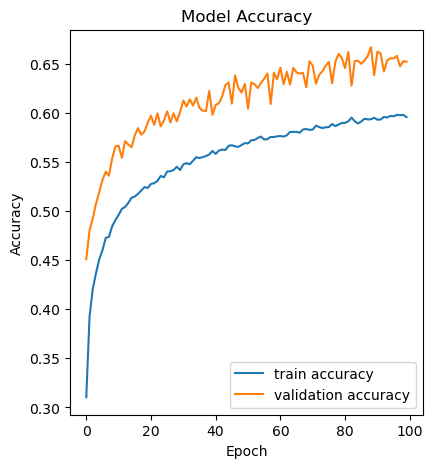

In [24]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="validation accuracy")
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()

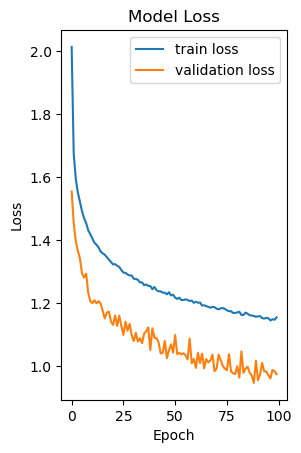

In [25]:
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()